![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/5.Spark_OCR.ipynb)

# Spark OCR


## Blogposts and videos

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)

- [Installing Spark NLP and Spark OCR in air-gapped networks (offline mode)
](https://medium.com/spark-nlp/installing-spark-nlp-and-spark-ocr-in-air-gapped-networks-offline-mode-f42a1ee6b7a8)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

## Healthcare NLP for Data Scientists Course

If you are not familiar with the components in this notebook, you can check [Healthcare NLP for Data Scientists Udemy Course](https://www.udemy.com/course/healthcare-nlp-for-data-scientists/) and the [MOOC Notebooks](https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/Spark_NLP_Udemy_MOOC/Healthcare_NLP) for each components.

**Colab Setup**

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing Spark OCR
! pip install --upgrade -q spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.0 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare"
!pip -q install --upgrade spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import sparkocr
import sys
from pyspark.sql import SparkSession
from sparkocr import start
import base64
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from sparkocr.enums import *
from sparkocr.utils import display_images, display_image

In [3]:
# Start spark
spark = sparkocr.start(secret=SPARK_OCR_SECRET,
                       nlp_version=PUBLIC_VERSION
                       )

Spark version: 3.4.0
Spark NLP version: 5.3.1
Spark NLP for Healthcare version: 5.3.1
Spark OCR version: 5.3.1



## Pdf to Text


In [4]:
!wget -q -O sample_doc.pdf http://www.asx.com.au/asxpdf/20171103/pdf/43nyyw9r820c6r.pdf

In [5]:
# Transform PDF document to images per page
pdf_to_image = PdfToImage()\
      .setInputCol("content")\
      .setOutputCol("image")\
      .setResolution(100)

# Run OCR
ocr = ImageToText()\
      .setInputCol("image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(65)
      # .setKeepLayout(True) \ # to preserve the layout of the input

pdf_to_text_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr
])

In [7]:
pdf = 'sample_doc.pdf'
pdf_example_df = spark.read.format("binaryFile").load(pdf).cache()

In [8]:
result = pdf_to_text_pipeline.transform(pdf_example_df).cache()

In [9]:
result.select("pagenum","text", "confidence").show()

+-------+--------------------+----------------+
|pagenum|                text|      confidence|
+-------+--------------------+----------------+
|      0|digital RE.\n\nAS...|89.5408469306098|
+-------+--------------------+----------------+



In [10]:
result.select("text").collect()

[Row(text='digital RE.\n\nASX ANNOUNCEMENT\n3 November 2017\n\nNotice Pursuant to Paragraph 708A(5)(e) of the Corporations Act\n2001 ("Act")\n\nDigitalX Limited (ASX:DCC) (DCC or the Company) confirms that the Company has today\nissued 620,000 Fully Paid Ordinary Shares (Shares) upon exercise of 620,000 Unlisted\nOptions exercisable at $0.0324 Expiring 14 September 2019 and 3,725,000 Shares upon\nexercise of 3,725,000 Unlisted Incentive Options exercisable at $0.08 expiring 10 February\n2018.\n\nThe Act restricts the on-sale of securities issued without disclosure, unless the sale is exempt\nunder section 708 or 708A of the Act. By giving this notice, a sale of the Shares noted above\nwill fall within the exemption in section 708A(S) of the Act.\n\nThe Company hereby notifies ASX under paragraph 708A(5)(e) of the Act that:\n(a) the Company issued the Shares without disclosure to investors under Part 6D.2 of\nthe Act;\n(b) _asatthe date of this notice, the Company has complied with the 

In [11]:
print("\n".join([row.text for row in result.select("text").collect()]))


digital RE.

ASX ANNOUNCEMENT
3 November 2017

Notice Pursuant to Paragraph 708A(5)(e) of the Corporations Act
2001 ("Act")

DigitalX Limited (ASX:DCC) (DCC or the Company) confirms that the Company has today
issued 620,000 Fully Paid Ordinary Shares (Shares) upon exercise of 620,000 Unlisted
Options exercisable at $0.0324 Expiring 14 September 2019 and 3,725,000 Shares upon
exercise of 3,725,000 Unlisted Incentive Options exercisable at $0.08 expiring 10 February
2018.

The Act restricts the on-sale of securities issued without disclosure, unless the sale is exempt
under section 708 or 708A of the Act. By giving this notice, a sale of the Shares noted above
will fall within the exemption in section 708A(S) of the Act.

The Company hereby notifies ASX under paragraph 708A(5)(e) of the Act that:
(a) the Company issued the Shares without disclosure to investors under Part 6D.2 of
the Act;
(b) _asatthe date of this notice, the Company has complied with the provisions of Chapter
2M of the 

###  With Skew Correction

In [12]:
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from sparkocr.utils import display_image
from sparkocr.metrics import score

In [13]:
def ocr_pipeline(skew_correction=False):

    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage()\
          .setInputCol("content")\
          .setOutputCol("image")\
          .setResolution(100)

    # Image skew corrector
    skew_corrector = ImageSkewCorrector()\
          .setInputCol("image")\
          .setOutputCol("corrected_image")\
          .setAutomaticSkewCorrection(skew_correction)

    # Run OCR
    ocr = ImageToText()\
          .setInputCol("corrected_image")\
          .setOutputCol("text")

    pipeline_ocr = PipelineModel(stages=[
        pdf_to_image,
        skew_corrector,
        ocr
    ])

    return pipeline_ocr

In [14]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/400_rot.pdf

In [15]:
pdf_rotated_df = spark.read.format("binaryFile").load('400_rot.pdf').cache()

In [16]:
pdf_pipeline = ocr_pipeline(False)

result = pdf_pipeline.transform(pdf_rotated_df).cache()

In [17]:
result.show()

+--------------------+--------------------+-------+--------------------+-----------+-------+-----------+--------------------+-----------------+---------+--------------------+--------------------+
|                path|    modificationTime| length|               image|total_pages|pagenum|documentnum|     corrected_image|       confidence|exception|                text|           positions|
+--------------------+--------------------+-------+--------------------+-----------+-------+-----------+--------------------+-----------------+---------+--------------------+--------------------+
|file:/content/400...|2024-04-15 20:09:...|2240141|{file:/content/40...|          1|      0|          0|{file:/content/40...|92.89510854085286|         |FOREWORD\n\nElect...|[{[{FOREWORD\n\n,...|
+--------------------+--------------------+-------+--------------------+-----------+-------+-----------+--------------------+-----------------+---------+--------------------+--------------------+



In [18]:
result.select("pagenum").collect()[0].pagenum

0


    Image #0:
    Origin: file:/content/400_rot.pdf
    Resolution: 100 dpi
    Width: 826 px
    Height: 1169 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


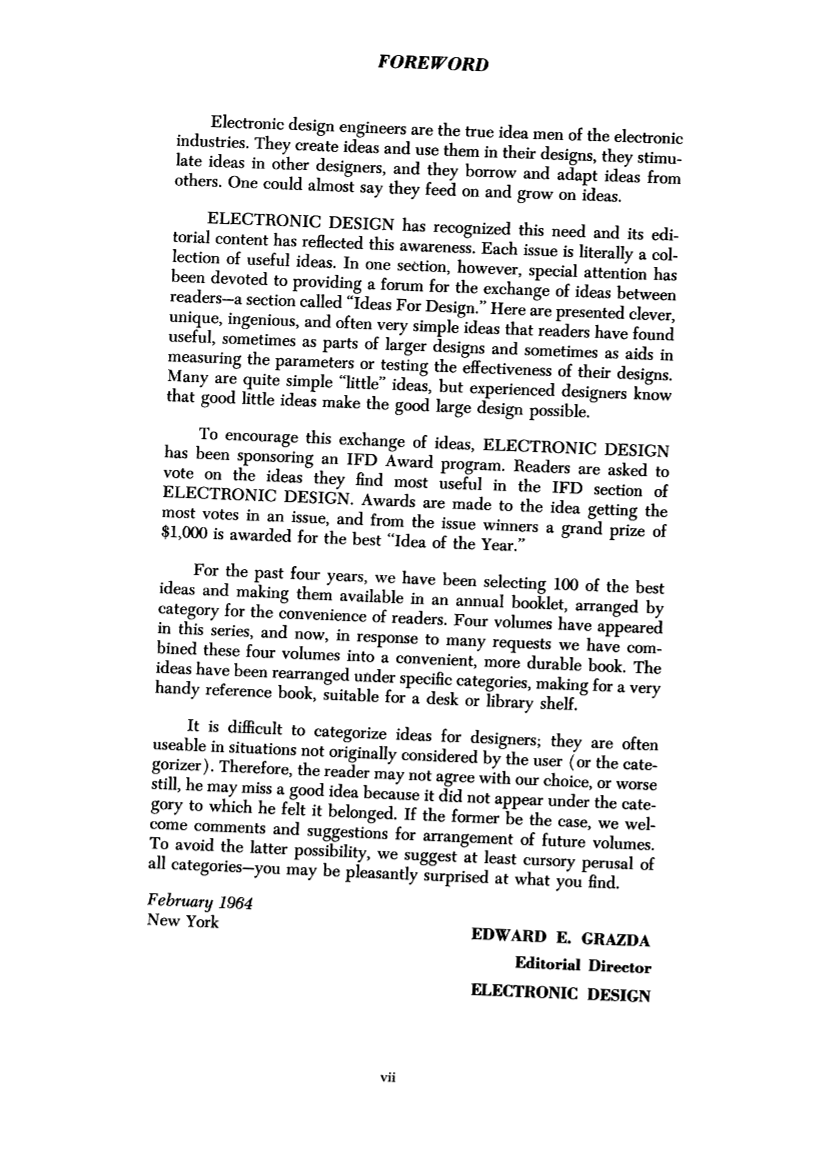

In [19]:
display_image(result.select("image").collect()[0].image)

### Display recognized text without skew correction


In [20]:
result.select("pagenum","text", "confidence").show()

+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|FOREWORD\n\nElect...|92.89510854085286|
+-------+--------------------+-----------------+



In [21]:
print("\n".join([row.text for row in result.select("text").collect()]))

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas,

torial content has reflected this awareness. Each issue is literally a col-
lection of useful ideas. In one section, however, special attention has

unique, ingenious, and often very simple ideas that readers have found
useful, sometimes as parts of larger designs and sometimes as aids in

To encourage this exchange of ideas, ELECTRONIC DESIGN
has been sponsoring an IFD Award program. Readers are asked to
vote on the ideas they find most useful in the IFD section of
ELECTRONIC DESIGN. Awards are made to the idea getting the
most votes in an issue, and from the issue winners a grand prize of
$1,000 is awarded for the best “Idea of the Year.”

It is difficult to categorize ideas for designers; they are often
use

### Display results with skew correction

In [22]:
pdf_pipeline_corrected = ocr_pipeline(True)

corrected_result = pdf_pipeline_corrected.transform(pdf_rotated_df).cache()

print("\n".join([row.text for row in corrected_result.select("text").collect()]))


FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

ELECTRONIG DESIGN has recognized this need and its edi-
torial content has reflected this awareness. Each issue is literally a cal-
lection of useful ideas. In one section, however, special attention has
been devoted to providing a forum for the exchange of ideas between
readers~a section called “Ideas For Design.” Here are presented clever,
unique, ingenious, and often very simple ideas that readers have found
useful, sometimes as parts of larger designs and sometimes as aids in
measuring the parameters or testing the effectiveness of their designs.
Many are quite simple “little” ideas, but experienced designers know
that good little ideas make the good large design possible.

To encourage this exchange of id

In [23]:
corrected_result.select("pagenum","text", "confidence").show()


+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|FOREWORD\n\nElect...|92.86057472229004|
+-------+--------------------+-----------------+



### Display skew corrected images


    Image #0:
    Origin: file:/content/400_rot.pdf
    Resolution: 100 dpi
    Width: 866 px
    Height: 1197 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


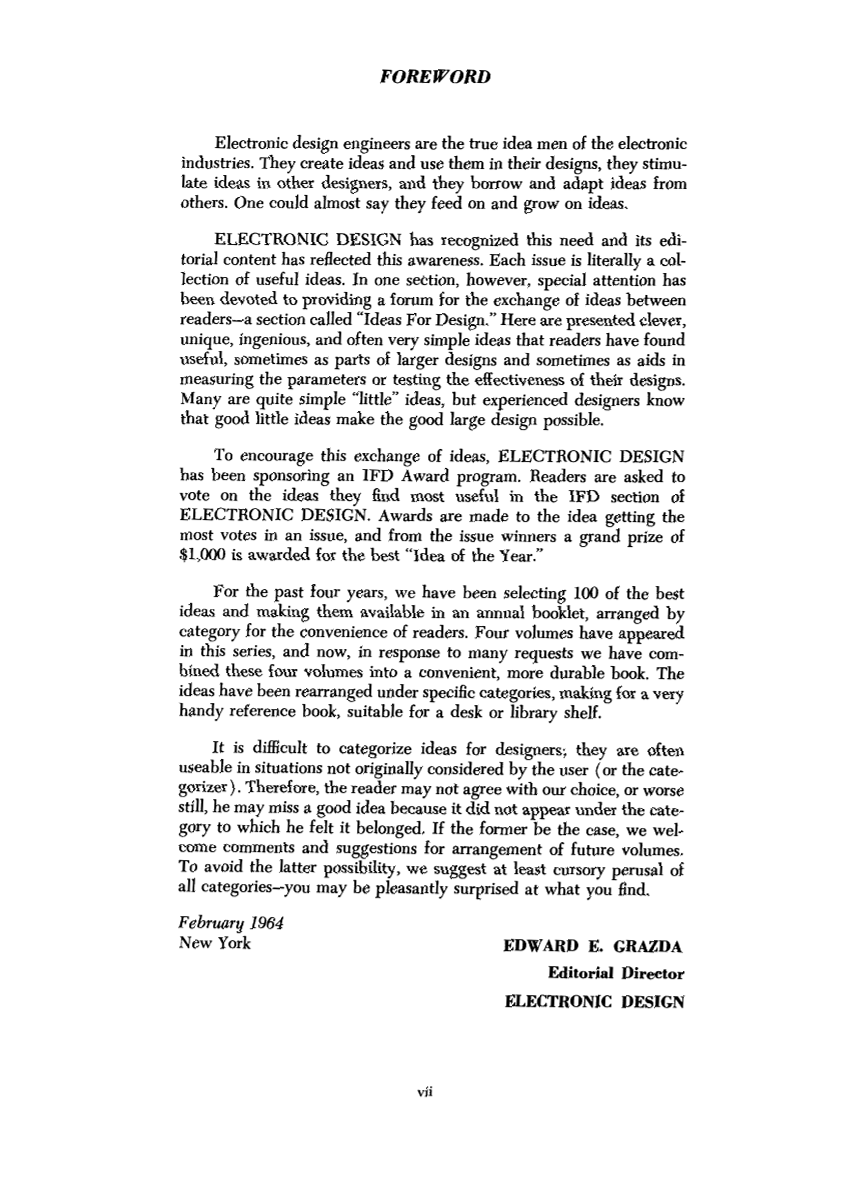

In [24]:
display_image(corrected_result.select("corrected_image").collect()[0].corrected_image)

### Compute score and compare
Read original text and calculate scores for both results.

In [25]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/400.txt

In [26]:
detected = "\n".join([row.text for row in result.collect()])
corrected_detected = "\n".join([row.text for row in corrected_result.collect()])

# read original text
pdf_rotated_text = open('400.txt', "r").read()

# compute scores
detected_score = score(pdf_rotated_text, detected)
corrected_score = score(pdf_rotated_text, corrected_detected)

#  print scores
print("Score without skew correction: {0}".format(detected_score))
print("Score with skew correction: {0}".format(corrected_score))

Score without skew correction: 0.6008403361344538
Score with skew correction: 0.9502458210422812


## Reading multiple pdfs from folder

In [27]:
pdf_path = "/content/*.pdf"

pdfs = spark.read.format("binaryFile").load(pdf_path).cache()
#images = spark.read.format("binaryFile").load('text_with_noise.png').cache()

pdfs.count()

2

In [28]:
# Transforrm PDF document to images per page
pdf_to_image = PdfToImage()\
      .setInputCol("content")\
      .setOutputCol("image")\
      .setResolution(100)

# Run OCR
ocr = ImageToText()\
      .setInputCol("image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(65)\
      .setIgnoreResolution(False)

ocr_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr
])


In [29]:
results = ocr_pipeline.transform(pdfs)

In [30]:
results.columns

['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'confidence',
 'exception',
 'text',
 'positions']

In [31]:
results.select('path','confidence','text').show()

+--------------------+-----------------+--------------------+
|                path|       confidence|                text|
+--------------------+-----------------+--------------------+
|file:/content/400...|92.89510854085286|FOREWORD\n\nElect...|
|file:/content/sam...| 89.5408469306098|digital RE.\n\nAS...|
+--------------------+-----------------+--------------------+



### Recognize text from PDFs and store results to PDF with text layout

In [32]:
from sparkocr.utils import display_pdf_file

# Transforrm PDF document to images per page
pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setResolution(100)

# Run OCR and render results to PDF
ocr = ImageToTextPdf() \
    .setInputCol("image") \
    .setOutputCol("pdf_page")

# Assemble multipage PDF
pdf_assembler = PdfAssembler() \
    .setInputCol("pdf_page") \
    .setOutputCol("pdf")

pdf_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr,
    pdf_assembler
])

In [33]:
!wget -q -O sample_doc.pdf http://www.asx.com.au/asxpdf/20171103/pdf/43nyyw9r820c6r.pdf

pdf = 'sample_doc.pdf'
pdf_example_df = spark.read.format("binaryFile").load(pdf).cache()

In [34]:
pdf_example_df.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/content/sam...|2023-03-13 22:07:41|212973|[25 50 44 46 2D 3...|
+--------------------+-------------------+------+--------------------+



In [35]:
result = pdf_pipeline.transform(pdf_example_df)

In [36]:
result.show()

+--------------------+--------------------+---------+
|                path|                 pdf|exception|
+--------------------+--------------------+---------+
|file:/content/sam...|[25 50 44 46 2D 3...|         |
+--------------------+--------------------+---------+



In [37]:
pdf = result.select("pdf").head().pdf

In [38]:
with open("searchable.pdf", "wb") as pdfFile:
  pdfFile.write(pdf)

## Image processing after reading a pdf

In [39]:
from sparkocr.enums import *

# Read binary as image
pdf_to_image = PdfToImage()\
  .setInputCol("content")\
  .setOutputCol("image")\
  .setResolution(100)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()\
  .setInputCol("image")\
  .setOutputCol("binarized_image")\
  .setBlockSize(91)\
  .setOffset(50)

# Apply morphology opening
opening = ImageMorphologyOperation()\
  .setKernelShape(KernelShape.SQUARE)\
  .setOperation(MorphologyOperationType.OPENING)\
  .setKernelSize(3)\
  .setInputCol("binarized_image")\
  .setOutputCol("opening_image")

# Remove small objects
remove_objects = ImageRemoveObjects()\
  .setInputCol("opening_image")\
  .setOutputCol("corrected_image")\
  .setMinSizeObject(130)

# Image Layout Analyzer for detect regions
image_layout_analyzer = ImageLayoutAnalyzer()\
  .setInputCol("corrected_image")\
  .setOutputCol("region")\

draw_regions = ImageDrawRegions()\
  .setInputCol("corrected_image")\
  .setInputRegionsCol("region")\
  .setOutputCol("image_with_regions")

# Run tesseract OCR for corrected image
ocr_corrected = ImageToText()\
  .setInputCol("corrected_image")\
  .setOutputCol("corrected_text")\
  .setPositionsCol("corrected_positions")\
  .setConfidenceThreshold(65)

# Run OCR for original image
ocr = ImageToText()\
  .setInputCol("image")\
  .setOutputCol("text")

# OCR pipeline
image_pipeline = PipelineModel(stages=[
    pdf_to_image,
    binarizer,
    opening,
    remove_objects,
    image_layout_analyzer,
    draw_regions,
    ocr,
    ocr_corrected
])

In [40]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/pdfs/noised.pdf

In [41]:
image_df = spark.read.format("binaryFile").load('noised.pdf').cache()
image_df.show()

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/content/noi...|2024-04-15 20:10:...|2115939|[25 50 44 46 2D 3...|
+--------------------+--------------------+-------+--------------------+



In [42]:
result = image_pipeline.transform(image_df).cache()

In [ ]:
for r in result.distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)

    print("Corrected: %s" % r.path)
    display_image(r.corrected_image)

### Results with original image

In [44]:
from termcolor import colored

grouped_results = result.groupBy("path", "pagenum").agg(F.concat_ws("", F.collect_list("text")).alias("text"))
for row in grouped_results.collect():
    print(colored("Filename:\n%s , page: %d" % (row.path, row.pagenum), "red"))
    print("Recognized text:\n%s" % row.text)

Filename:
file:/content/noised.pdf , page: 0
Recognized text:
 

Dat

 

 

 

 

 

Sample No. __5031 : 23 ;
* Original request made by Mr. C. b. Tucker, Jr. "on “ipojes
C Sample specifications written by John H. M. Bohlken
_ BLEND, CASING _—-RECASING FINAL FLAVOR MENTHOL FLAVOR

“ OLD GOLD STRAIGHT Tobacco Blend

 

Control for Sample No. 5030

   

 

OLD GOLD STRAIGHT

  
  

 

85 mm.
Circumference. 25.3. mm. 5
Paper ~~. Ecusta 556
Firnness OLD GOLD STRAIGHT .

 

OLD GOLD STRAIGHT :
OLD GOLD STRAIGHT  Wrappings: .

    

 

Labels OLD GOLD STRAIGHT
C . Filter Length. OLD GOLD STRAIGHT, Closures: Standard Blue
~ Tear Tape-- Gold
. Cartons OLD GOLD STRAIGHT

  

=. Requirement: 5 Markings-~

One Tray .

Sample number on each
pack and carton

 

bf a :
ple" 4.6: Lo
boratory Analysis: —~ 7 <A V/s . ew +
Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,
Benzo (A) Pyrene Analyses — 7-/¢-CF- @.( ssi/ek
Responsibility:
Tobacco Blend -- - Manufacturing - A. Kraus. we
Filte

### Results with corrected image


In [45]:
grouped_results = result.groupBy("path", "pagenum").agg(F.concat_ws("", F.collect_list("corrected_text")).alias("corrected_text"))
for row in grouped_results.collect():
    print(colored("Filename:\n%s , page: %d" % (row.path, row.pagenum), "red"))
    print("Recognized text:\n%s" % row.corrected_text)

Filename:
file:/content/noised.pdf , page: 0
Recognized text:



In [46]:
result.columns

['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'binarized_image',
 'opening_image',
 'corrected_image',
 'region',
 'image_with_regions',
 'confidence',
 'text',
 'positions',
 'confidence',
 'exception',
 'corrected_text',
 'corrected_positions']

### Abbyy output

In [47]:
abbyy = """-----
% Date: 7/16/68
X*: I; * • ■ Sample No. 5031___ — .*
•* Original request made by _____Mr. C. L. Tucker, Jr. on
Sample specifications written by
BLEND CASING RECASING
OLD GOLD STRAIGHT Tobacco Blend
Control for Sample No. 5030
John H. M. Bohlken
FINAL FLAVOR
) 7/10/68
MENTHOL FLAVOR
• Cigarettes; * . .v\ . /,*, *, S •
Brand --------- OLD GOLD STRAIGHT -V . ••••
; . L e n g t h ------- — 85 mm. . : '
Circumference-- 25.3 mm. • ' *;. • •
P a p e r ---------- Ecusta 556 • * .
F i r m n e s s---- —— OLD GOLD STRAIGHT . ! •■'
D r a w ___________ OLD GOLD STRAIGHT
W e i g h t --------- 0LD GOLD STRAIGHT Wrappings: « -
Tipping Paper — — *
p H n f —. — — _ _ ~ L a b e l s ----OLD GOLD STRAIGHT
( • Filter Length-- . — Closures--- Standard Blue .
^ ^ ; • Tear Tape— Gold
Cartons --- OLD GOLD STRAIGHT
s Requirements: . - •' • Markings-- Sample number on each
• pack and carton Laboratory----- One Tray .
O t h e r s --------- * , s • • . 4
Laboratory A n a l ysis^ I " '/***• * 7 ' ^ ^
Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,
Benzo (A) Pyrene Analyses — J-ZZ-Zf'- (£. / •
Responsibility;
Tobacco B l e n d ------Manufacturing - A. Kraus . . * -
Filter Production--- —
• Making & P a c k i n g---Product Development , John H. M. Bohlken
Shipping -----------
Reports:
t
Written by — John H. M. Bohlken
Original to - Mr. C. L. Tucker, Jr.
Copies t o ---Dr. A. W. Spears
• 9 ..
"""

### Display original and corrected images with regions


In [ ]:
for r in result.select("path","image","image_with_regions").distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)

    print("Corrected: %s" % r.path)
    display_image(r.image_with_regions)

## Image (or Natural Scene) to Text

In [49]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/images/text_with_noise.png

Original: file:/content/text_with_noise.png

    Image #0:
    Origin: file:/content/text_with_noise.png
    Resolution: 95 dpi
    Width: 1095 px
    Height: 134 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


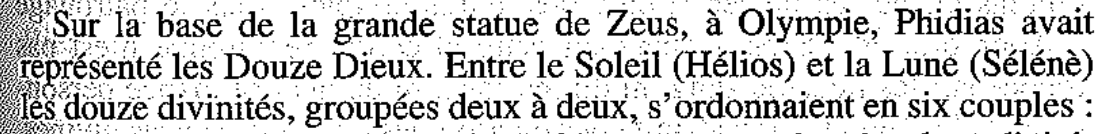

Binarized

    Image #0:
    Origin: file:/content/text_with_noise.png
    Resolution: 95 dpi
    Width: 2190 px
    Height: 268 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


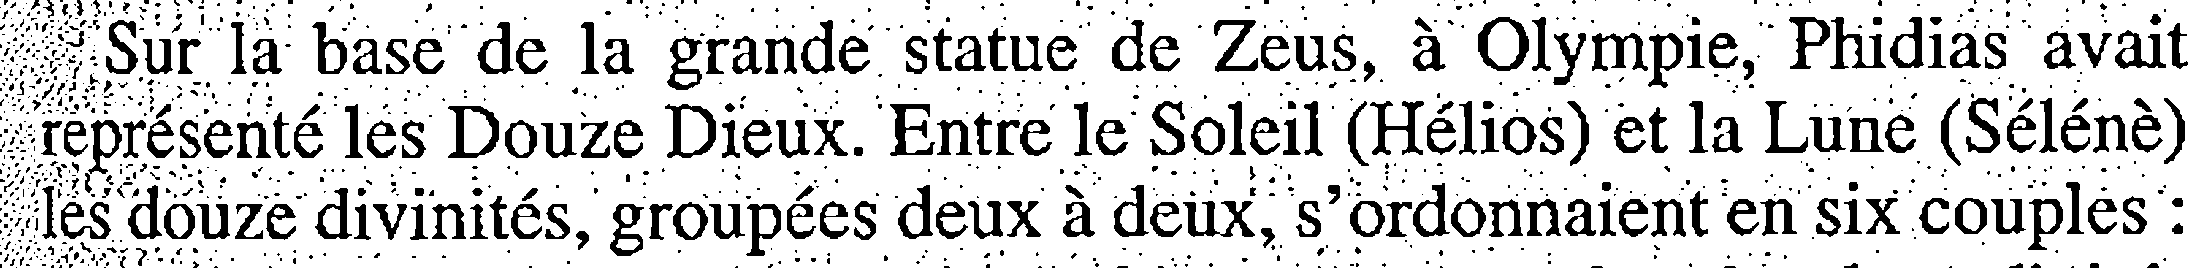

Removing objects

    Image #0:
    Origin: file:/content/text_with_noise.png
    Resolution: 95 dpi
    Width: 2190 px
    Height: 268 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


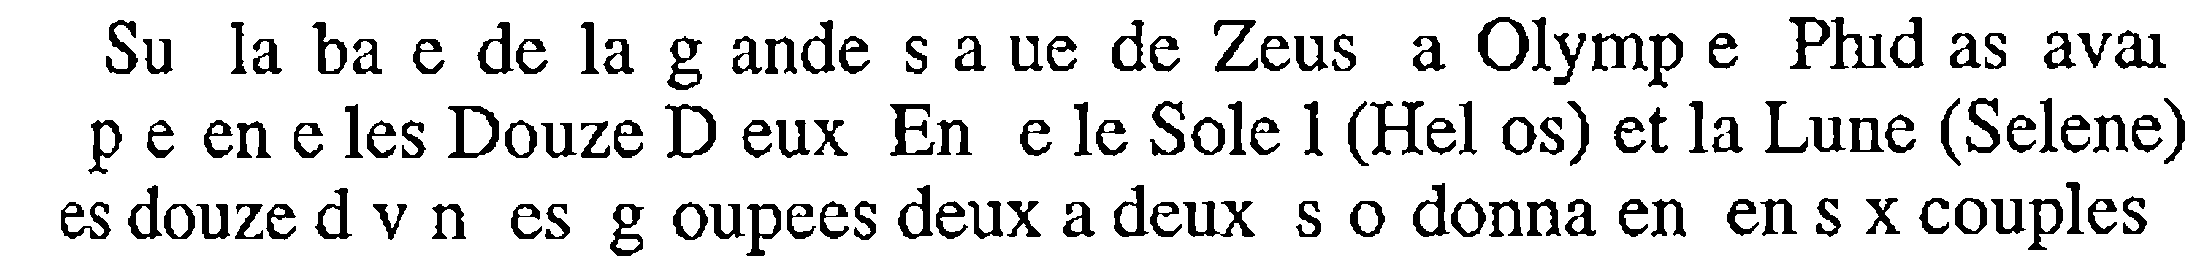

In [50]:
image_df = spark.read.format("binaryFile").load('text_with_noise.png').cache()

# Read binary as image
binary_to_image = BinaryToImage()
binary_to_image.setInputCol("content")
binary_to_image.setOutputCol("image")

# Scale image
scaler = ImageScaler()
scaler.setInputCol("image")
scaler.setOutputCol("scaled_image")
scaler.setScaleFactor(2.0)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()
binarizer.setInputCol("scaled_image")
binarizer.setOutputCol("binarized_image")
binarizer.setBlockSize(71)
binarizer.setOffset(65)

remove_objects = ImageRemoveObjects()
remove_objects.setInputCol("binarized_image")
remove_objects.setOutputCol("cleared_image")
remove_objects.setMinSizeObject(400)
remove_objects.setMaxSizeObject(4000)

# Run OCR
ocr = ImageToText()
ocr.setInputCol("cleared_image")
ocr.setOutputCol("text")
ocr.setConfidenceThreshold(50)
ocr.setIgnoreResolution(False)

# OCR pipeline
noisy_pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    remove_objects,
    ocr
])


result = noisy_pipeline \
.transform(image_df) \
.cache()


for r in result.distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)
    print("Binarized")
    display_image(r.binarized_image)
    print("Removing objects")
    display_image(r.cleared_image)


In [51]:
print("\n".join([row.text for row in result.select("text").collect()]))

Su la ba e de la g ande saue de Zeus a Olympe Phid as avai
pe ene les Douze D eux En ele Sole | (Hel os) et la Lune (Selene)
esdouze dv n es g oupees deux adeux s o donna en ens x couples



### Text from Scene

In [52]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/natural_scene.jpeg

Original: file:/content/natural_scene.jpeg

    Image #0:
    Origin: file:/content/natural_scene.jpeg
    Resolution: 0 dpi
    Width: 640 px
    Height: 480 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


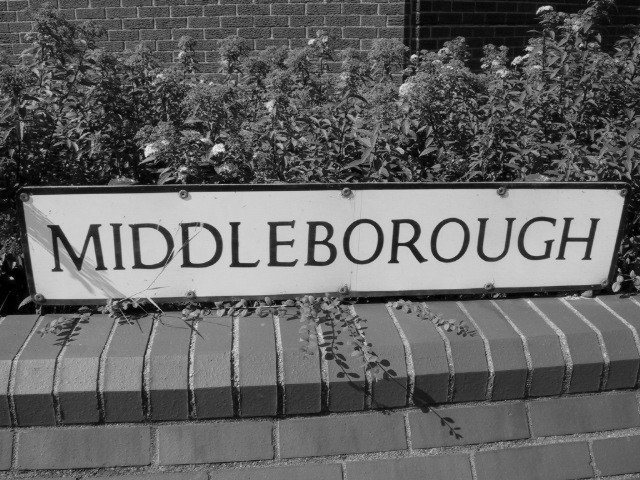

Binarized

    Image #0:
    Origin: file:/content/natural_scene.jpeg
    Resolution: 0 dpi
    Width: 1280 px
    Height: 960 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


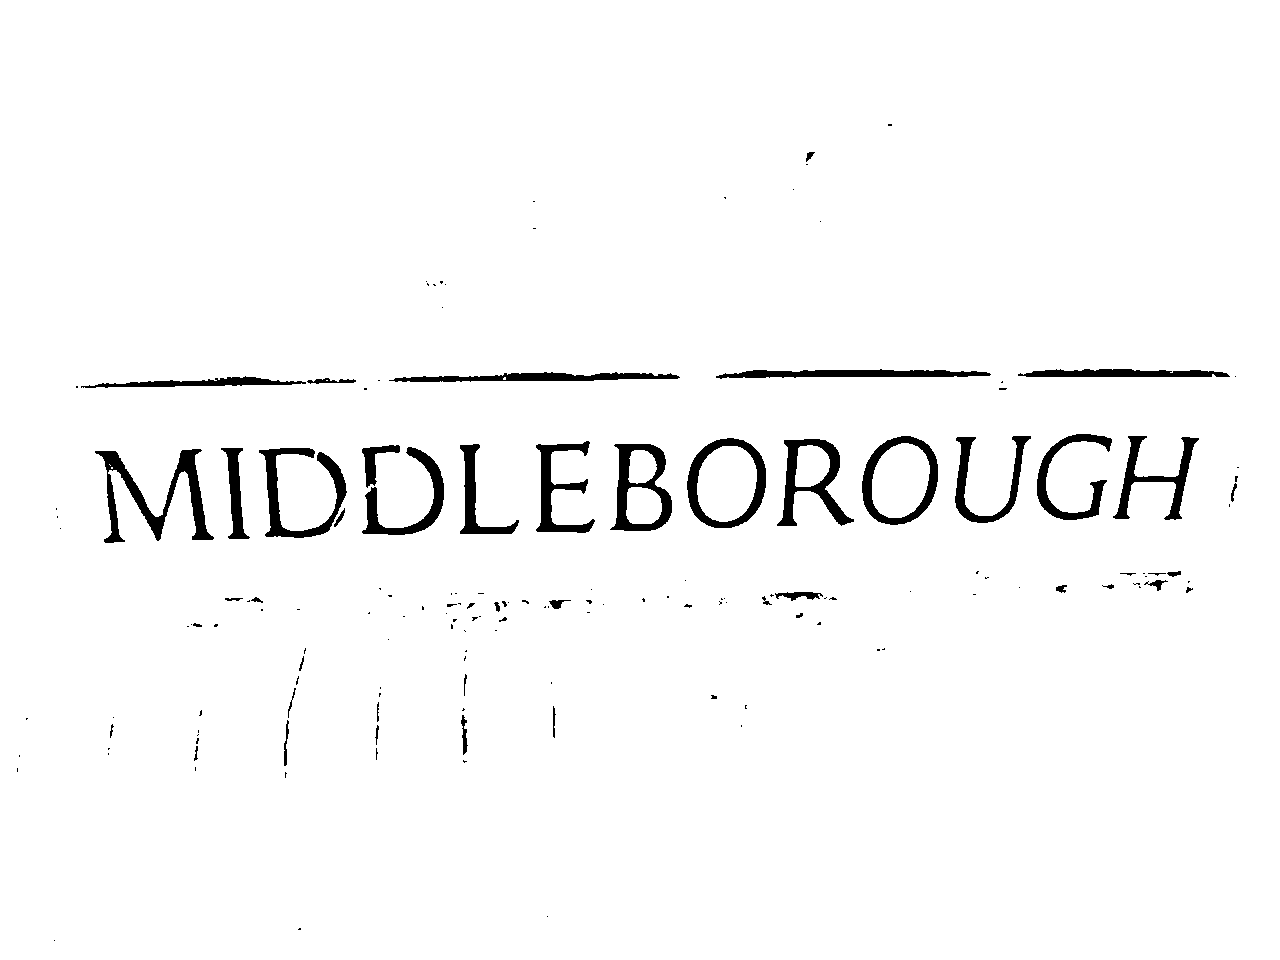

Removing objects

    Image #0:
    Origin: file:/content/natural_scene.jpeg
    Resolution: 0 dpi
    Width: 1280 px
    Height: 960 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


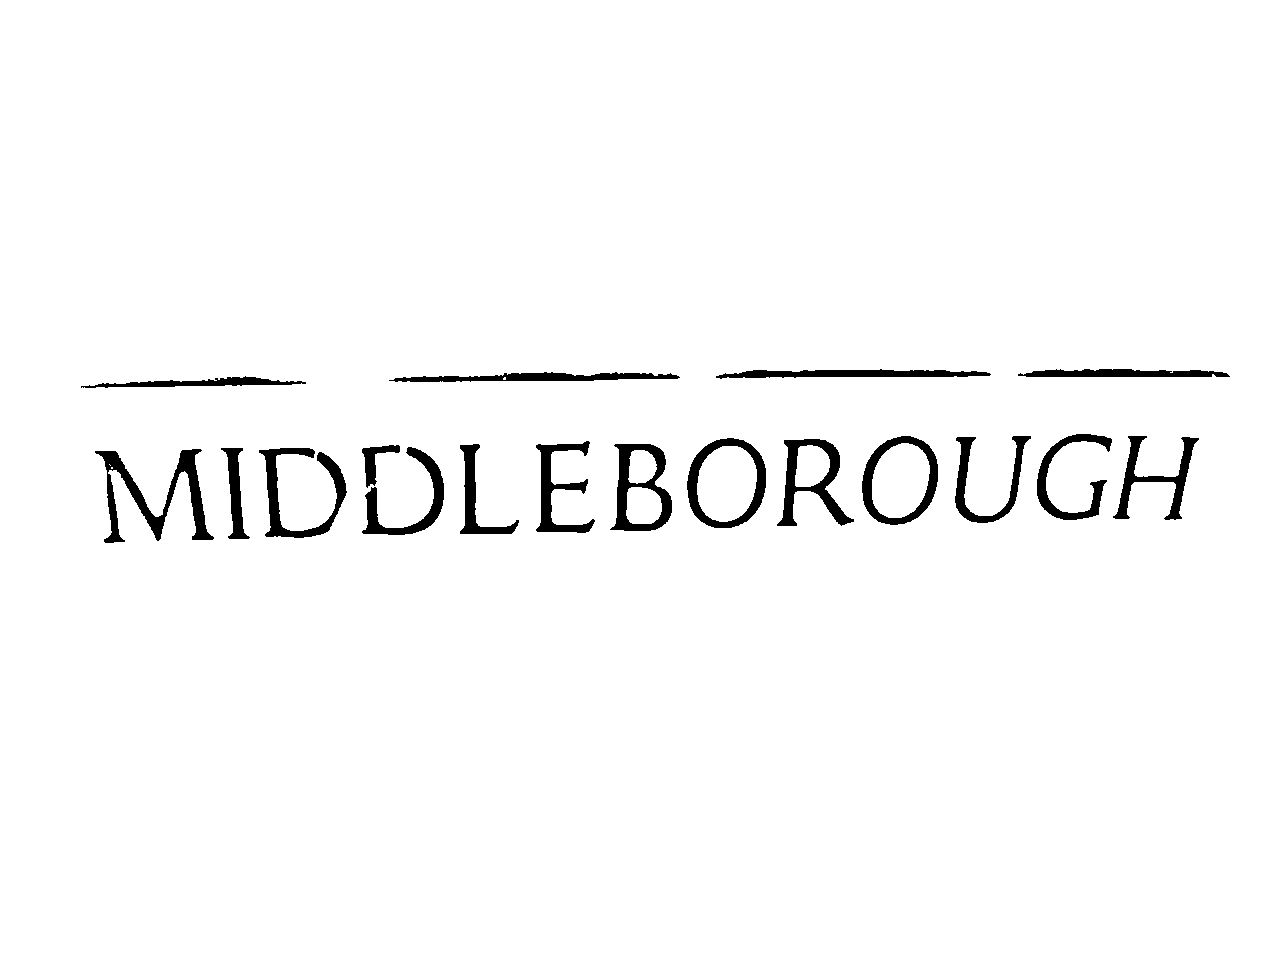

Morphology closing

    Image #0:
    Origin: file:/content/natural_scene.jpeg
    Resolution: 0 dpi
    Width: 1280 px
    Height: 960 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


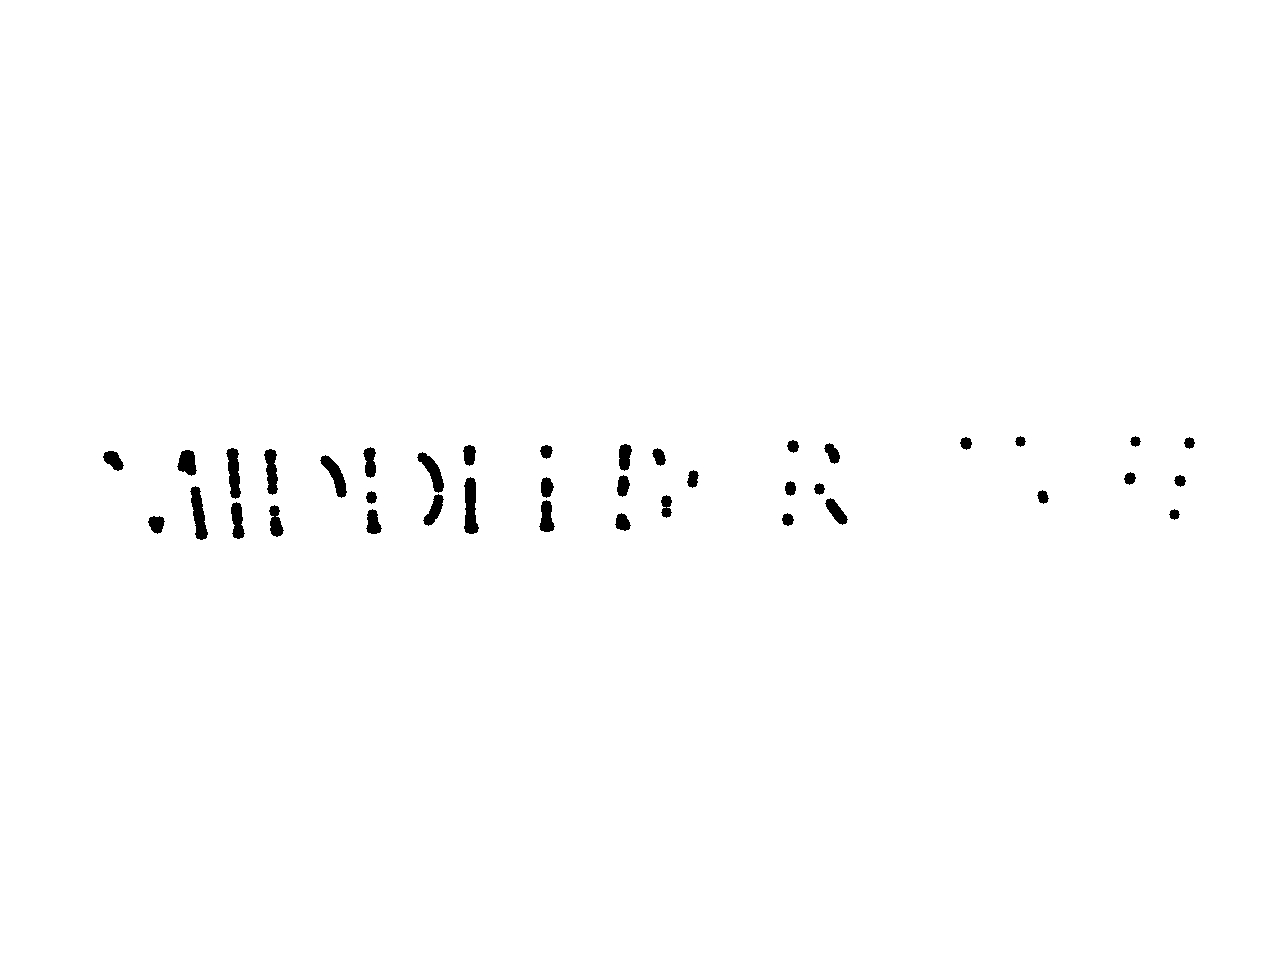

In [53]:
image_df = spark.read.format("binaryFile").load('natural_scene.jpeg').cache()

# Apply morphology opening
morpholy_operation = ImageMorphologyOperation()
morpholy_operation.setKernelShape(KernelShape.DISK)
morpholy_operation.setKernelSize(5)
morpholy_operation.setOperation("closing")
morpholy_operation.setInputCol("cleared_image")
morpholy_operation.setOutputCol("corrected_image")

# Run OCR
ocr = ImageToText()
ocr.setInputCol("corrected_image")
ocr.setOutputCol("text")
ocr.setConfidenceThreshold(50)
ocr.setIgnoreResolution(False)

# OCR pipeline
scene_pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    remove_objects,
    morpholy_operation,
    ocr
])

result = scene_pipeline \
.transform(image_df) \
.cache()


for r in result.distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)
    print("Binarized")
    display_image(r.binarized_image)
    print("Removing objects")
    display_image(r.cleared_image)
    print("Morphology closing")
    display_image(r.corrected_image)

## DOCX Processing (version 1.10.0)

### Read DOCX document as binary file

In [54]:
import pkg_resources
doc_example = pkg_resources.resource_filename('sparkocr', 'resources/ocr/docs/doc2.docx')
doc_example_df = spark.read.format("binaryFile").load(doc_example).cache()

### DocxtoText

#### Extract text using DocToText transformer

In [55]:
from sparkocr.transformers import *

doc_to_text = DocToText()
doc_to_text.setInputCol("content")
doc_to_text.setOutputCol("text")

result = doc_to_text.transform(doc_example_df)

#### Display result DataFrame

In [56]:
result.show()

+--------------------+--------------------+------+--------------------+---------+-------+
|                path|    modificationTime|length|                text|exception|pagenum|
+--------------------+--------------------+------+--------------------+---------+-------+
|file:/usr/local/l...|2024-04-15 20:06:...| 33260|Sample Document\n...|     null|      0|
+--------------------+--------------------+------+--------------------+---------+-------+



#### Display extracted text

In [57]:
print("\n".join([row.text for row in result.select("text").collect()]))

Sample Document
This document was created using accessibility techniques for headings, lists, image alternate text, tables, and columns. It should be completely accessible using assistive technologies such as screen readers.
Headings
There are eight section headings in this document. At the beginning, "Sample Document" is a level 1 heading. The main section headings, such as "Headings" and "Lists" are level 2 headings. The Tables section contains two sub-headings, "Simple Table" and "Complex Table," which are both level 3 headings.
Lists
The following outline of the sections of this document is an ordered (numbered) list with six items. The fifth item, "Tables," contains a nested unordered (bulleted) list with two items.
Headings 
Lists 
Links 
Images 
Tables 
Simple Tables 
Complex Tables 
Columns 
Links
In web documents, links can point different locations on the page, different pages, or even downloadable documents, such as Word documents or PDFs:
Top of this Page
Sample Document
Sa

### DocxToTextTable
#### (Extracting table data from Microsoft DOCX documents)

#### Preview document using DocToPdf and PdfToImage transformers


    Image #0:
    Origin: file:/usr/local/lib/python3.10/dist-packages/sparkocr/resources/ocr/docs/doc2.docx
    Resolution: 100 dpi
    Width: 849 px
    Height: 1100 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


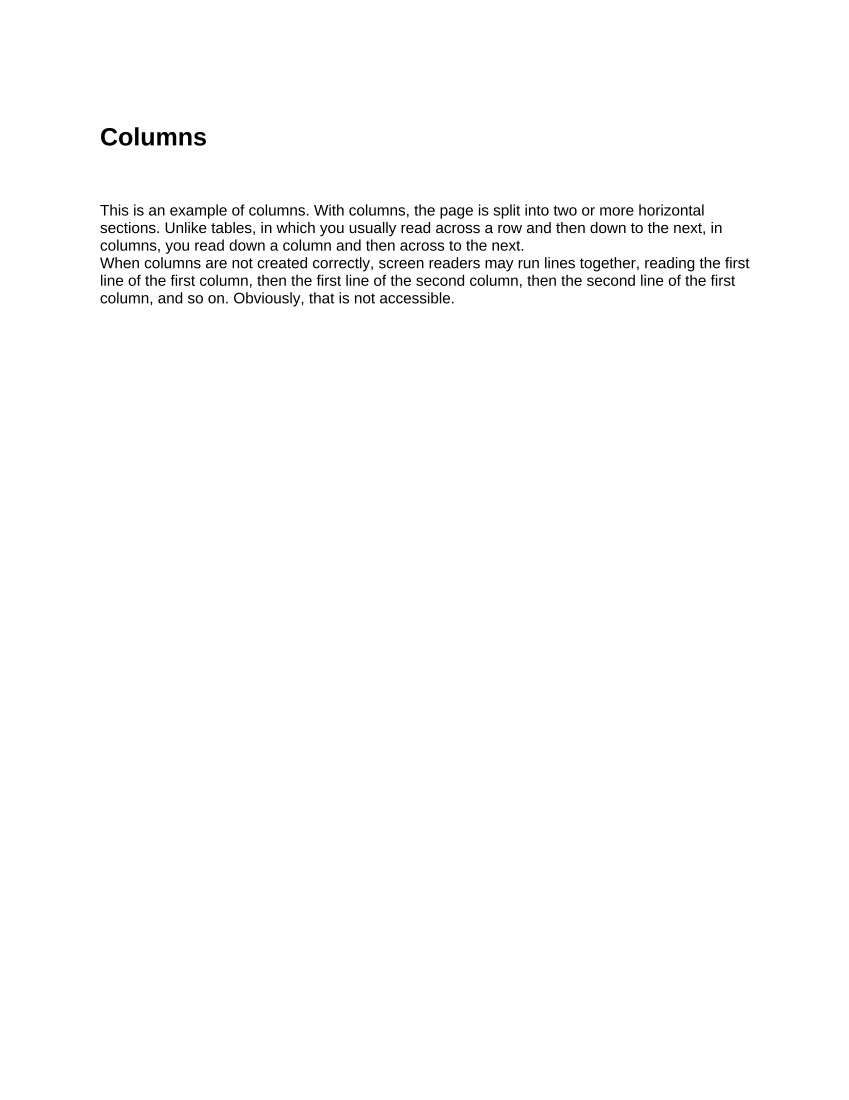


    Image #0:
    Origin: file:/usr/local/lib/python3.10/dist-packages/sparkocr/resources/ocr/docs/doc2.docx
    Resolution: 100 dpi
    Width: 849 px
    Height: 1100 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


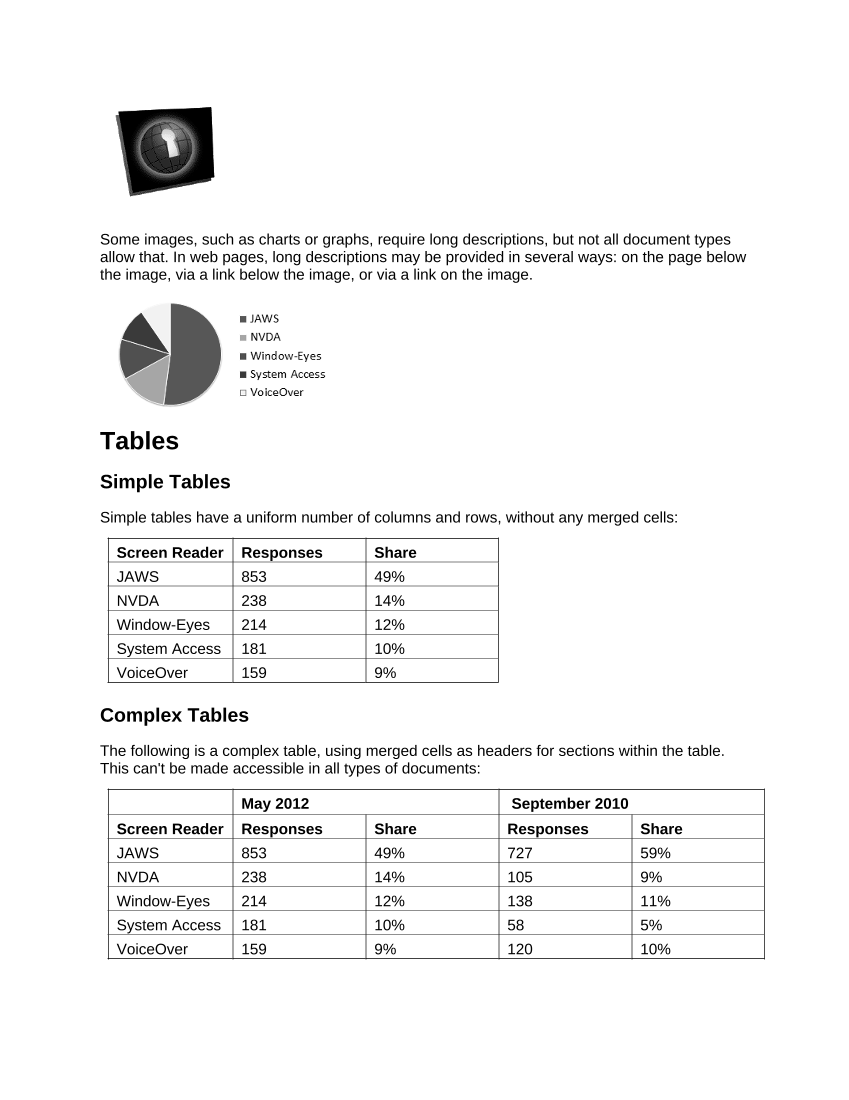


    Image #0:
    Origin: file:/usr/local/lib/python3.10/dist-packages/sparkocr/resources/ocr/docs/doc2.docx
    Resolution: 100 dpi
    Width: 849 px
    Height: 1100 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


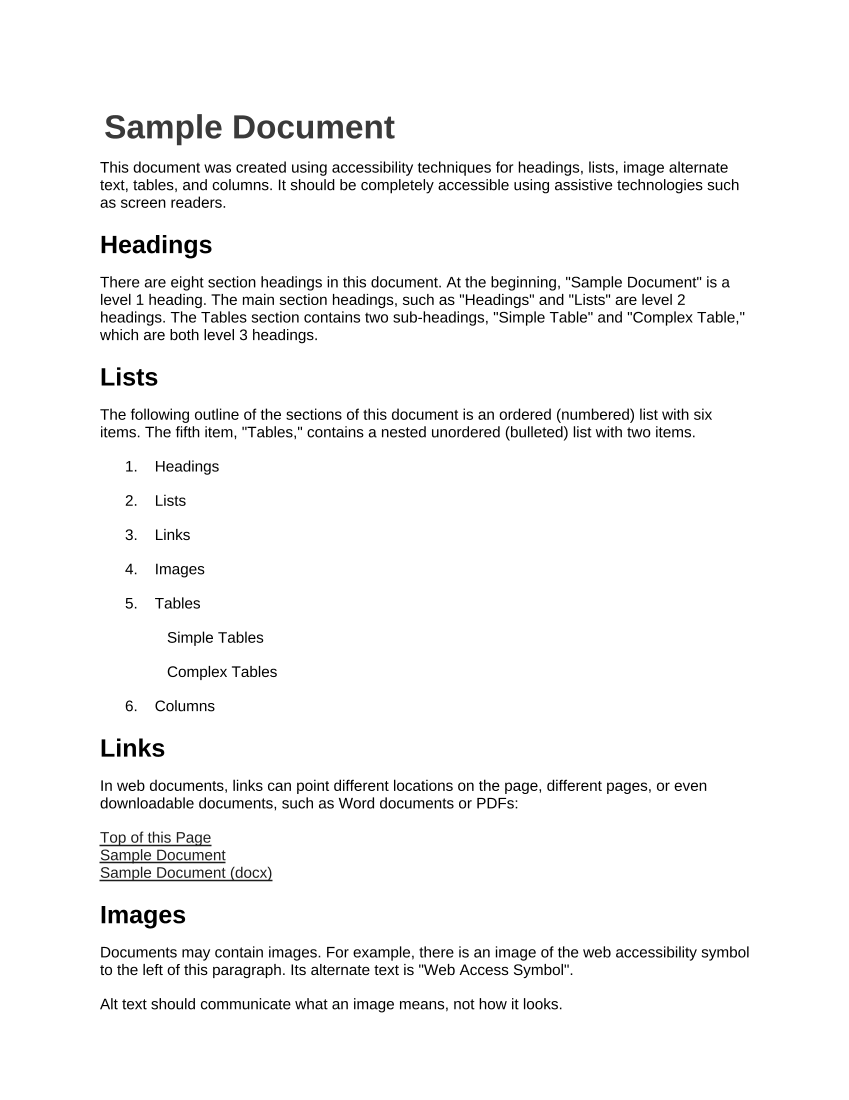

In [58]:
image_df = PdfToImage().setResolution(100).transform(DocToPdf().setOutputCol("content").transform(doc_example_df))
for r in image_df.select("image").collect():
    display_image(r.image)

#### Extract text using DocToText transformer

In [59]:
doc_to_table = DocToTextTable()
doc_to_table.setInputCol("content")
doc_to_table.setOutputCol("tables")

result = doc_to_table.transform(doc_example_df)

result.show()

+--------------------+--------------------+------+--------------------+---------+
|                path|    modificationTime|length|              tables|exception|
+--------------------+--------------------+------+--------------------+---------+
|file:/usr/local/l...|2024-04-15 20:06:...| 33260|{{0, 0, 0.0, 0.0,...|     null|
|file:/usr/local/l...|2024-04-15 20:06:...| 33260|{{1, 0, 0.0, 0.0,...|     null|
+--------------------+--------------------+------+--------------------+---------+



In [60]:
result.select(result["tables.chunks"].getItem(3)["chunkText"]).show(truncate=False)

+-----------------------------------------+
|tables.chunks AS chunks#9896[3].chunkText|
+-----------------------------------------+
|[Window-Eyes, 214, 12%]                  |
|[NVDA, 238, 14%, 105, 9% ]               |
+-----------------------------------------+



#### Display extracted data in JSON format

In [61]:
import json
df_json = result.select("tables").toJSON()
for row in df_json.collect():
    print(json.dumps(json.loads(row), indent=4))

{
    "tables": {
        "area": {
            "index": 0,
            "page": 0,
            "x": 0.0,
            "y": 0.0,
            "width": 0.0,
            "height": 0.0,
            "score": 0.0,
            "label": "0",
            "angle": 0.0
        },
        "chunks": [
            [
                {
                    "chunkText": "Screen Reader",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 90.0,
                    "height": 0.0
                },
                {
                    "chunkText": "Responses",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 95.75,
                    "height": 0.0
                },
                {
                    "chunkText": "Share",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 95.75,
                    "height": 0.0
                }
            ],
            [
                {
              

## Text to Pdf

In [62]:
def pipeline():
    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage() \
        .setInputCol("content") \
        .setOutputCol("image") \
        .setResolution(100) \
        .setKeepInput(True)

    # Run OCR
    ocr = ImageToText() \
        .setInputCol("image") \
        .setOutputCol("text") \
        .setConfidenceThreshold(60) \
        .setIgnoreResolution(False) \
        .setPageSegMode(PageSegmentationMode.SPARSE_TEXT)

    # Render results to PDF
    textToPdf = TextToPdf() \
        .setInputCol("positions") \
        .setInputImage("image") \
        .setOutputCol("pdf")

    pipeline = PipelineModel(stages=[
        pdf_to_image,
        ocr,
        textToPdf
    ])

    return pipeline

In [63]:
# !wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/MT_00.pdf
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/test_document.pdf

In [64]:
# pdf_example_df = spark.read.format("binaryFile").load('MT_00.pdf').cache()
pdf_example_df = spark.read.format("binaryFile").load('test_document.pdf').cache()

In [65]:
result = pipeline().transform(pdf_example_df).cache()

In [66]:
result.columns

['path', 'text', 'pdf', 'exception']

In [ ]:
display_image(PdfToImage().setResolution(100).transform(pdf_example_df).select("image").collect()[0].image)

In [68]:
# Store results to pdf file
pdf = result.select("pdf").head().pdf

pdfFile = open("result.pdf", "wb")

pdfFile.write(pdf)

pdfFile.close()


    Image #0:
    Origin: file:/content/test_document.pdf
    Resolution: 100 dpi
    Width: 1777 px
    Height: 2444 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


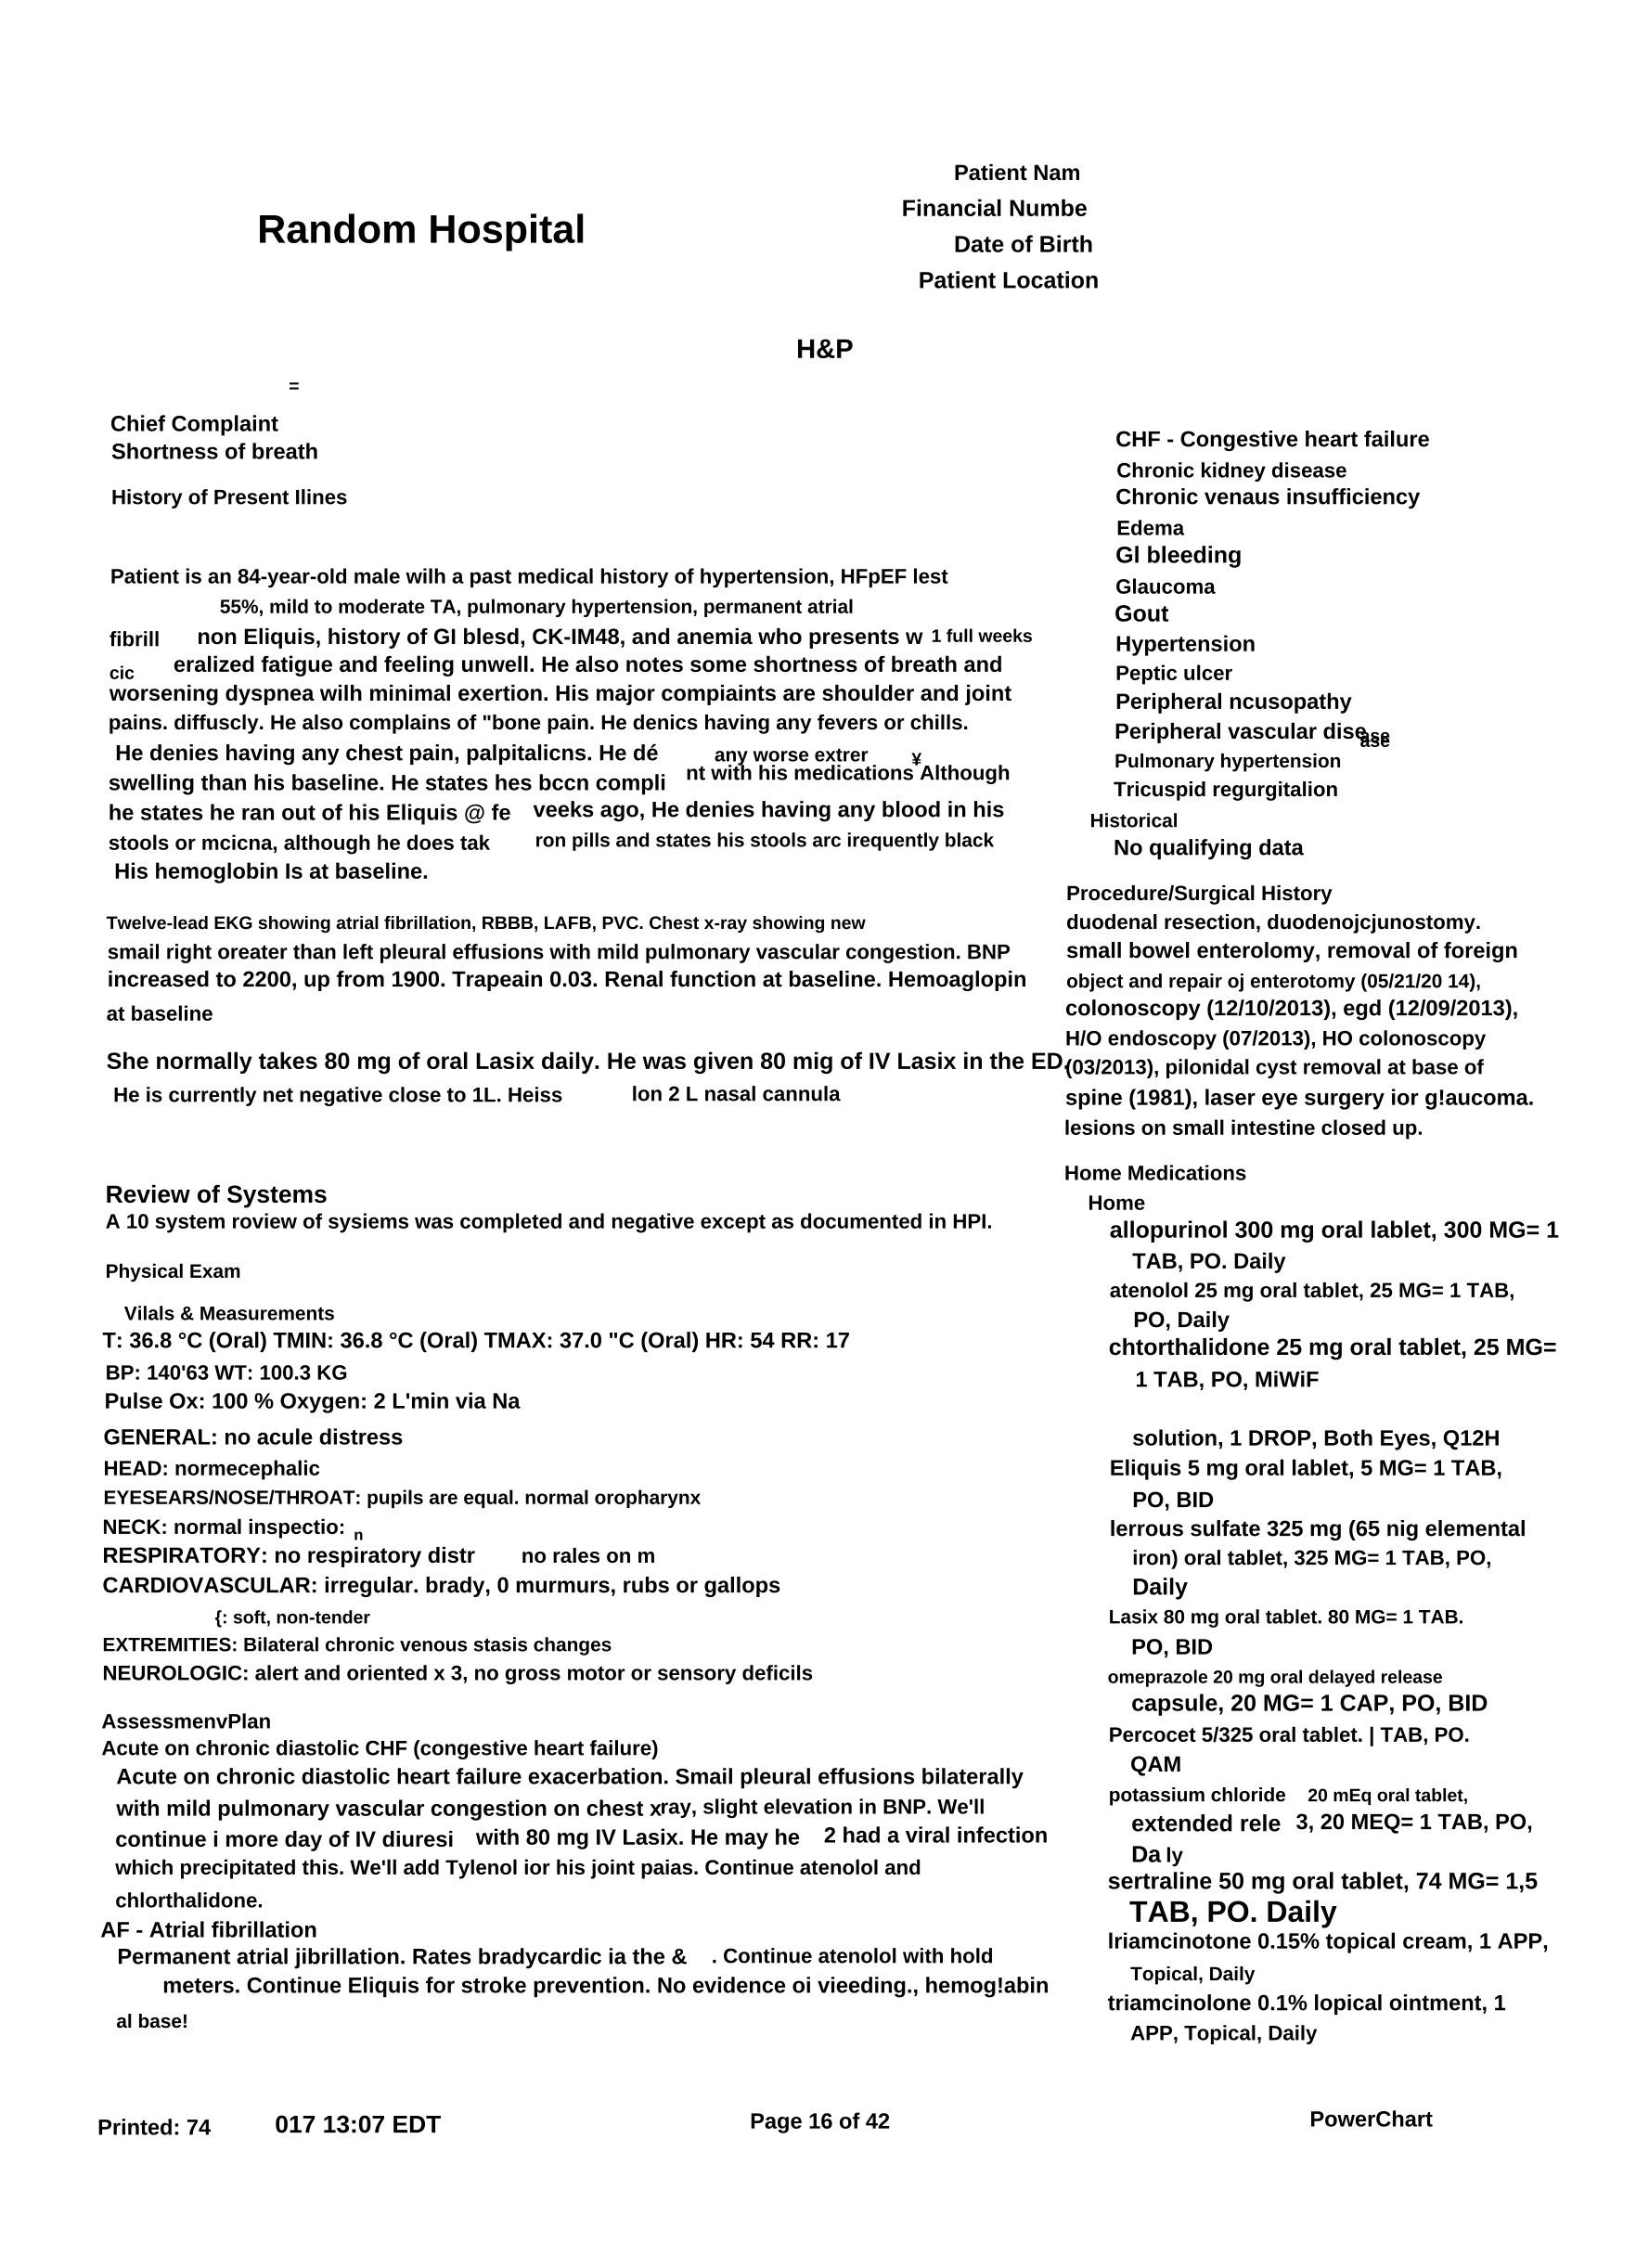


    Image #0:
    Origin: file:/content/test_document.pdf
    Resolution: 100 dpi
    Width: 1777 px
    Height: 2333 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


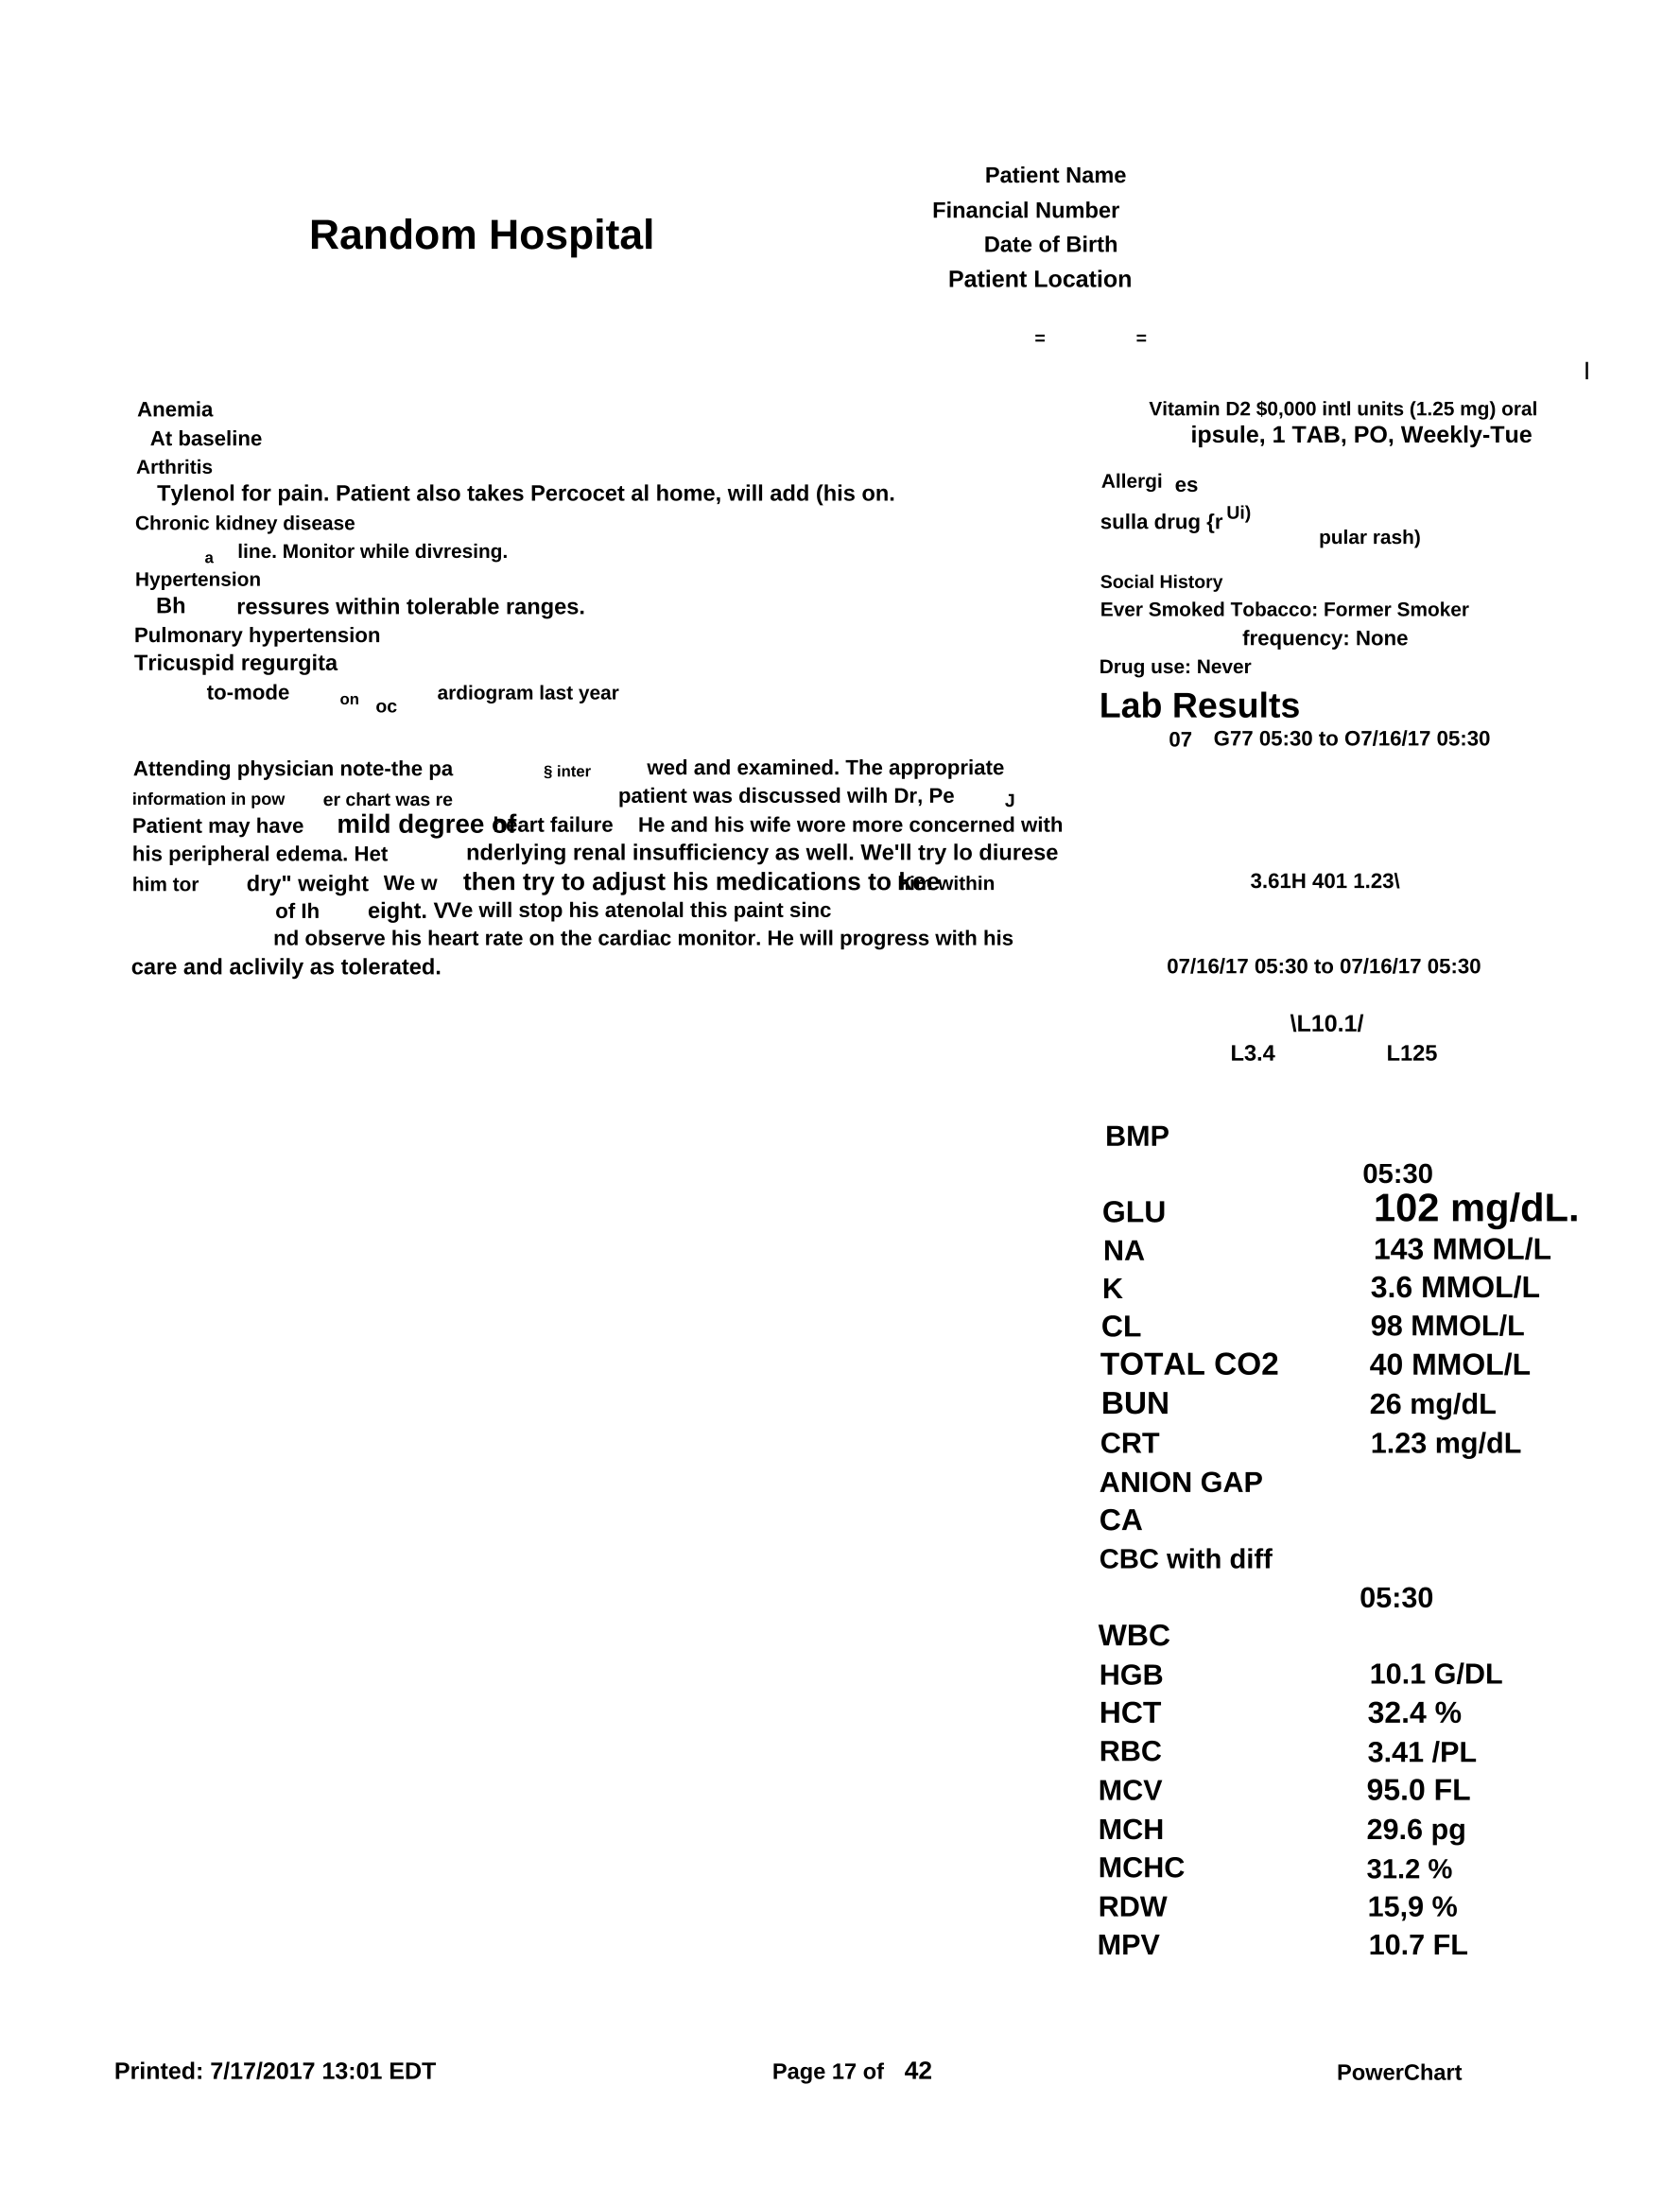

In [69]:
# Convert pdf to image and display¶

image_df = PdfToImage() \
    .setInputCol("pdf") \
    .setOutputCol("image") \
    .setResolution(100) \
    .transform(result.select("pdf", "path"))

for r in image_df.collect():
    display_image(r.image)


## Working with PPT Documents

### Read PPT document

In [70]:
# Read PPT document as binary file
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/Spark_NLP_NER.pptx
ppt_example_df = spark.read.format("binaryFile").load('Spark_NLP_NER.pptx').cache()


    Image #0:
    Origin: file:/content/Spark_NLP_NER.pptx
    Resolution: 100 dpi
    Width: 826 px
    Height: 1169 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


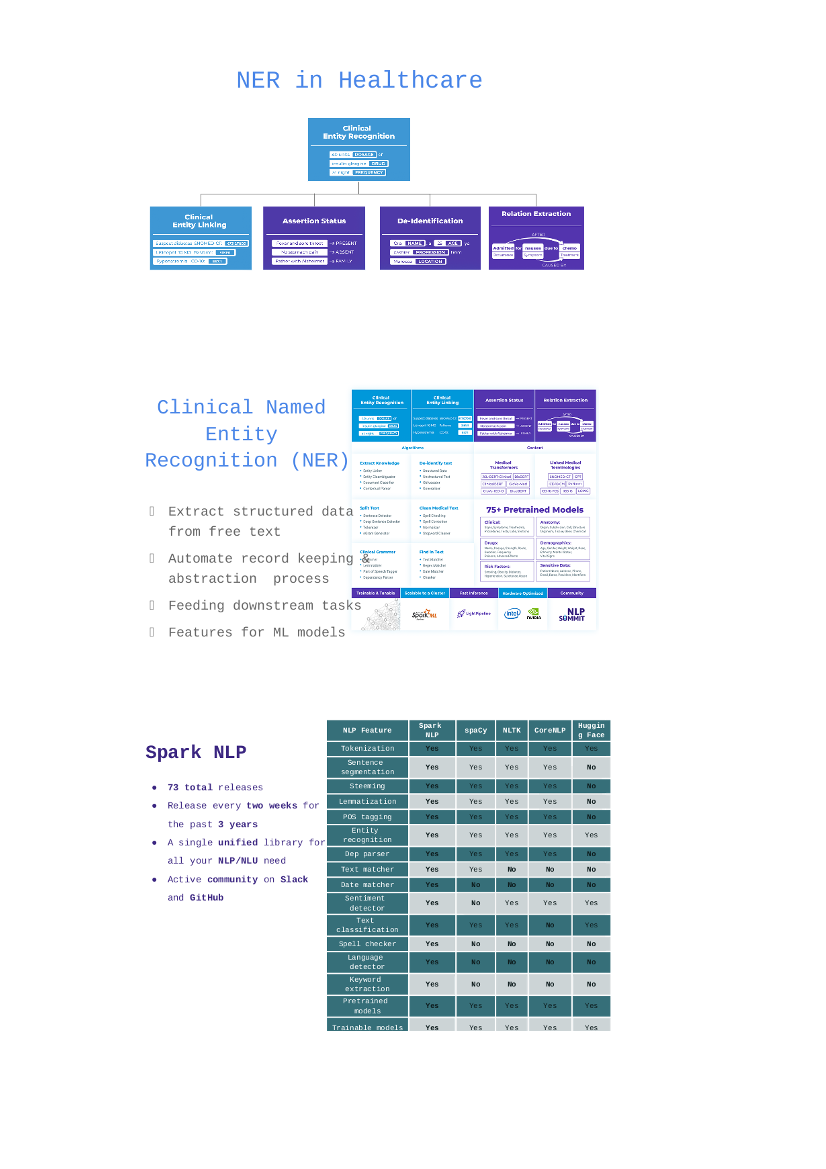

In [71]:
#Read PPT document as binary file¶

# convert PPT to PDF
pdf_df = PptToPdf() \
    .setOutputCol("content") \
    .transform(ppt_example_df)

# Convert PDF to image for display
image_df = PdfToImage() \
    .setImageType(ImageType.TYPE_3BYTE_BGR) \
    .setResolution(100) \
    .transform(pdf_df)

display_images(image_df)

### Extracting table data from PPT documents

In [72]:
from sparkocr.transformers import *
from sparkocr.utils import display_images, display_tables, display_pdf
from pyspark.sql.functions import collect_list,col

In [73]:
# Preview document using PptToPdf and PdfToImage transformers¶
image_df = PptToPdf().setOutputCol("content").transform(ppt_example_df)

In [74]:
#Extract tables from PPT using PptToTextTable transformer¶

ppt_to_table = PptToTextTable()
ppt_to_table.setInputCol("content")
ppt_to_table.setOutputCol("table")

result = ppt_to_table.transform(ppt_example_df).cache()

In [75]:
result.show()

+--------------------+--------------------+-------+--------------------+---------+-------+
|                path|    modificationTime| length|               table|exception|pagenum|
+--------------------+--------------------+-------+--------------------+---------+-------+
|file:/content/Spa...|2024-04-15 20:11:...|4490997|{{0, 0, 304.01157...|     null|      0|
+--------------------+--------------------+-------+--------------------+---------+-------+



In [76]:
display_tables(result)

Filename: Spark_NLP_NER.pptx
Page: 0
Table: 0
Number of Columns: 6


col0,col1,col2,col3,col4,col5
NLP Feature,Spark NLP,spaCy,NLTK,CoreNLP,Hugging Face
Tokenization,Yes,Yes,Yes,Yes,Yes
Sentence segmentation,Yes,Yes,Yes,Yes,No
Steeming,Yes,Yes,Yes,Yes,No
Lemmatization,Yes,Yes,Yes,Yes,No
POS tagging,Yes,Yes,Yes,Yes,No
Entity recognition,Yes,Yes,Yes,Yes,Yes
Dep parser,Yes,Yes,Yes,Yes,No
Text matcher,Yes,Yes,No,No,No
Date matcher,Yes,No,No,No,No


## Dicom to Image

In [77]:
!mkdir dicom
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm -O /content/dicom/dicom_1.dcm
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-1.dcm  -O /content/dicom/dicom_2.dcm
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-2.dcm  -O /content/dicom/dicom_3.dcm


    Image #0:
    Origin: file:/content/dicom/dicom_3.dcm
    Resolution: 0 dpi
    Width: 914 px
    Height: 985 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


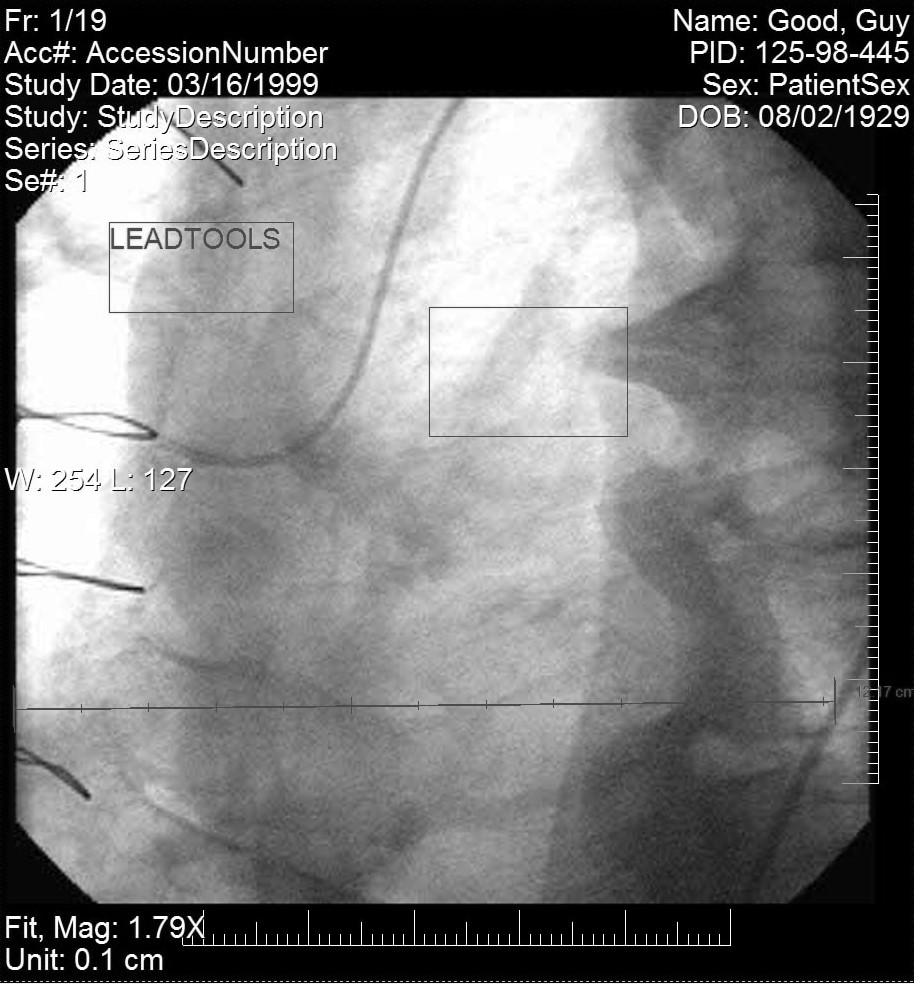


    Image #0:
    Origin: file:/content/dicom/dicom_2.dcm
    Resolution: 0 dpi
    Width: 800 px
    Height: 800 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


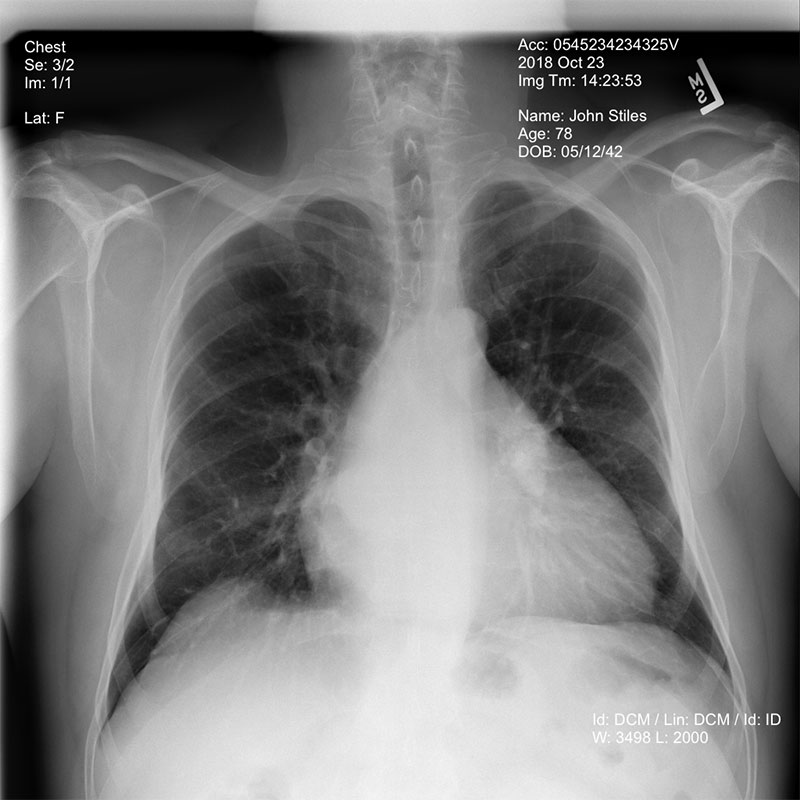

In [78]:
dicom_path = './dicom/*.dcm'

# Read dicom file as binary file
dicom_df = spark.read.format("binaryFile").load(dicom_path)

dicomToImage = DicomToImage() \
  .setInputCol("content") \
  .setOutputCol("image") \
  .setMetadataCol("meta")

data = dicomToImage.transform(dicom_df)

for image in data.collect():
      display_image(image.image)



In [79]:
# Extract text from image
ocr = ImageToText() \
    .setInputCol("image") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])

print("\n".join([row.text for row in ocr.transform(data).select("text").collect()]))

Fr: 1/19 Name: Good, Guy
Acc#: AccessionNumber PID: 125-98-445

Study Date: go 6/4 999 Sex: PatientSex
_ DOB:,08/02/1929

pur

 

LEADTOOLS

 

 

 

 

 

 

‘Acc: 0545234234325V

2018 Oct 23

Img Tm: 14:23:53
%

Name: John Stiles

 



## Spark OCR for recognize text and store results to HOCR

In [82]:
# Transforrm PDF document to images per page
pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setResolution(100) \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

# Run OCR
ocr = ImageToHocr() \
    .setInputCol("image") \
    .setOutputCol("hocr") \
    .setIgnoreResolution(False)

document_assembler = HocrDocumentAssembler() \
    .setInputCol("hocr") \
    .setOutputCol("document")

tokenizer = HocrTokenizer() \
    .setInputCol("hocr") \
    .setOutputCol("token") \

draw_annotations = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("token") \
    .setOutputCol("image_with_annotations") \
    .setFilledRect(False) \
    .setFontSize(10) \


pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr,
    document_assembler,
    tokenizer,
    draw_annotations
])

In [83]:
import pkg_resources
pdf_example = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/test_document.pdf')
pdf_example_df = spark.read.format("binaryFile").load(pdf_example).cache()

In [84]:
result = pipeline.transform(pdf_example_df).cache()

In [85]:
result.select("pagenum", "hocr").show()

+-------+--------------------+
|pagenum|                hocr|
+-------+--------------------+
|      1|  <div class='ocr...|
|      0|  <div class='ocr...|
+-------+--------------------+



In [ ]:
display_images(result, "image_with_annotations", width=1000)

In [87]:
from IPython.core.display import display, HTML
display(HTML(result.select("hocr").collect()[0].hocr))

## Text Detection in an Image using Regex Patterns

In [ ]:
import pkg_resources
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images


imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/text_detection/020_Yas_patella.jpg')
image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR).transform(image_df), "image")

In [89]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2.pretrained("image_text_detector_v2", "en", "clinical/ocr")
text_detector.setInputCol("image")
text_detector.setOutputCol("text_regions")
text_detector.setSizeThreshold(10)
text_detector.setScoreThreshold(0.9)
text_detector.setLinkThreshold(0.4)
text_detector.setTextThreshold(0.2)
text_detector.setWidth(1512)
#text_detector.setHeight(2016)

draw_regions = ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("text_regions")
draw_regions.setOutputCol("image_with_regions")
draw_regions.setRectColor(Color.green)
draw_regions.setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    draw_regions
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB


In [ ]:
result =  pipeline.transform(image_df).cache()
display_images(result, "image_with_regions")

In [91]:
# Define a new alphabet

symbols = """:$&(){}[]?/\\!><@=#-;,%_“.|'`"*#^+~€"""
numbers = "0123456789"
englishAlphabet = "abcdefghijklmnopqrstuvwxyz"
special = "β¢£©®—"

chars = symbols + numbers + englishAlphabet + englishAlphabet.upper() +special

with open('./custom_alphabet.txt', 'w') as alphabet_file:
    alphabet_file.write(chars)

In [92]:
entities =[
    {
        "id": "ref",
        "label": "REF",
        "patterns": ["\\d{4}-\\d{2}-\\d{3}"],
        "regex": True
    },
    {
        "id": "date",
        "label": "DATE",
        "patterns": ["\\d{4}-\\d{2}-\\d{2}"],
        "regex": True
    },
    {
        "id": "lot",
        "label": "LOT",
        "patterns": ["\\d{7}"],
        "regex": True
    }
]

with open('./entities.json', 'w') as jsonfile:
    json.dump(entities, jsonfile)

In [95]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("text_image") \
    .setDropCols(["image"]) \
    .setRotated(True) \
    .setImageType(ImageType.TYPE_BYTE_GRAY)

ocr = ImageToText() \
    .setInputCol("text_image") \
    .setOutputCol("text") \
    .setPageSegMode(PageSegmentationMode.SINGLE_WORD) \
    .setIgnoreResolution(False)

documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

entityRuler = EntityRulerApproach() \
    .setInputCols(["document", "token"]) \
    .setOutputCol("entities") \
    .setPatternsResource("entities.json") \
    .setAlphabetResource("./custom_alphabet.txt")

pipeline_nlp = Pipeline().setStages([
    splitter,
    ocr,
    documentAssembler,
    tokenizer,
    entityRuler
])

text_result = pipeline_nlp.fit(result).transform(result).cache()

In [96]:
text_result.selectExpr("explode(entities)").show(truncate=False)

+-------------------------------------------------------------------------------+
|col                                                                            |
+-------------------------------------------------------------------------------+
|{chunk, 1, 15, REFI1518-10-029, {entity -> REF, id -> ref, sentence -> 0}, []} |
|{chunk, 0, 7, [8455732, {entity -> LOT, id -> lot, sentence -> 0}, []}         |
|{chunk, 0, 14, REFI1518-20-029, {entity -> REF, id -> ref, sentence -> 0}, []} |
|{chunk, 0, 7, 19129475, {entity -> LOT, id -> lot, sentence -> 0}, []}         |
|{chunk, 1, 15, REFI1518-10-032, {entity -> REF, id -> ref, sentence -> 0}, []} |
|{chunk, 0, 9, 2026-04-30, {entity -> DATE, id -> date, sentence -> 0}, []}     |
|{chunk, 0, 7, 19707144, {entity -> LOT, id -> lot, sentence -> 0}, []}         |
|{chunk, 0, 15, IREFI1518-10-035, {entity -> REF, id -> ref, sentence -> 0}, []}|
|{chunk, 0, 7, 19691274, {entity -> LOT, id -> lot, sentence -> 0}, []}         |
|{chunk, 0, 9, 2

In [97]:
print(("").join([x.text for x in text_result.select("text").collect()]))

(REFI1518-10-029
ATTUNE™
[8455732
REFI1518-20-029
19129475
STERILE
PATELLA
MEDIALIZED
ANATOMIC
PATELLA
ATTUNE
MEMALIZED
DOME
29mm
CEMENTED
AOx™
29mm
CEMENTED
AOX™
(REFI1518-10-032
| STERILE |
2026-04-30
ATTUNE™
PATELLA MEDIALIZED
ANATOMIC
(REFI15 i°-20-032
ATTUNE™
19707144
32mm
CEMENTED
AOX™
PATELLA MEDIALIZEC
DOME
32mm
CEMENTED
AOX"*
IREFI1518-10-035
19691274
2026-01-31
(REFI1518-20-035
9675944
PATELLA
28mm
MEDIALIZED
CEMENTED
ANATOMIC.
AOX™
PATELLA MEDIALIZED
DOME
2021-01-07
35mm
CEMENTED
AOX™
(REFI1518-10-038
ATTUNE™
(REFI1518-20-038
9749663
PATEL
38mm
MEDIALIZED
CEMENTED
ANA’
AOx™
TOMIC
PATELLA
38mm
MEDIALIZED
CEMENTED.
AOX™
DOUE

